# Description

**Problem 1**: for dataset that measures the concentration of a sulfate in the blood of a baboon as a function of time (http://www.statsci.org/data/general/brunhild.html), I will build a linear regression of the log of the
concentration against the log of time, and:
  * (a) Prepare a plot showing the data points and the regression line in log-log coordinates.
  * (b) Prepare a plot showing the data points and the regression curve in the original coordinates.
  * (c) Plot the residual against the fitted values in log-log and in original coordinates.
  * (d) Use plots to explain whether regression is good or bad and why.
  
**Problem 2**: for dataset of measurements by M. Larner, made in 1996 (http://www.statsci.org/data/oz/physical.html), where measurements include body mass, and various diameters, I will build a linear regression of predicting the body
mass from these diameters, and:
  * (a) Plot the residual against the fitted values for your regression.
  * (b) Now regress the cube root of mass against these diameters. Plot the residual against the fitted values in both these cube root coordinates and in the original coordinates.
  * (c) Use plots to explain which regression is better.
  
**Problem 3**: for dataset of measurements by W. J. Nash, T. L. Sellers, S. R. Talbot, A. J. Cawthorn and W. B. Ford, made in 1992 (https://archive.ics.uci.edu/ml/datasets/Abalone) where are a variety of measurements of blacklip abalone (Haliotis rubra; delicious by repute) of various ages and genders, I will:
  * (a) Build a linear regression predicting the age from the measurements, ignoring gender and plot the residual against the fitted values.
  * (b) Build a linear regression predicting the age from the measurements, including gender. There are three levels for gender; I’m not sure whether this has to do with abalone biology or difficulty in determining gender. So I will represent gender numerically by choosing 1 for one level, 0 for another, and -1 for the third. Plot the residual against the fitted values.
  * (c) Build a linear regression predicting the log of age from the measurements, ignoring gender and plot the residual against the fitted values.
  * (d) Build a linear regression predicting the log age from the measurements, including gender, represented as above, and plot the residual against the fitted values.
  * (f) Improve these regressions by using a regularizer and obtain plots of the cross-validated prediction error.

---

# Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.lines as mlines
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 

# Linear regression

Function `linear_regression` fits a linear regression model, and takes the following two arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of data points, and `d` is the data dimension. 
2. `Y`: A numpy array of the shape `(N,)` where `N` is the number of data points.
3. `lam`: The regularization coefficient $\lambda$, which is a scalar positive value. 

and returns the linear regression weight vector 
$$\beta=\begin{bmatrix} \beta_0\\ \beta_1\\ \cdots \\ \beta_d \end{bmatrix}$$
which is a numpy array with a shape of `(d+1,1)`. 

Function should:
1. **Have an Intercept Weight**: In other words, fitting model should be minimizing the following mean-squared loss $$\mathcal{L}(\beta; X, Y, \lambda)^2 = \frac{1}{N}\sum_{i=1}^N \big(y^{(i)} - (\beta_0 + \beta_1 x_1^{(i)} + \beta_2 x_2^{(i)} +\cdots +\beta_d x_d^{(i)})\big)^2 + \lambda \beta^T \beta.$$ An easy way to do this is by concatenating a constant 1-column to the data matrix
   
2. **Never Raise An Error, and Return the Solution with the Smallest Euclidean Norm** in case the optimal weight vector is not unique. For instance, when the number of data points is smaller than the dimension, many optimal weight vectors exist. 

In [2]:
def linear_regression(X,Y,lam=0):
    N = X.shape[0]
    d = X.shape[1]
    
    X = np.insert(X, 0, 1, axis=1)
    I = np.identity(d+1)
    
    B = np.linalg.pinv((X.T @ X + I*lam*N)) @ (X.T @ Y)
    return B.reshape(-1,1)

Function `linear_predict` given the learned weights in the `linear_regression` function predicts the labels. 
Functions takes the following two arguments as input:
1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of data points, and `d` is the data dimension. 
2. `beta`: A numpy array of the shape `(d+1,1)` where `d` is the data dimension
$$\beta=\begin{bmatrix} \beta_0\\ \beta_1\\ \cdots \\ \beta_d \end{bmatrix}$$

Function produces the $\hat{y}$ numpy array with the shape of `(N,)`, whose $i^{th}$ element is defined as
$$\hat{y}^{(i)} = \beta_0 + \beta_1 x_1^{(i)} + \beta_2 x_2^{(i)} +\cdots +\beta_d x_d^{(i)}$$.

In [3]:
def linear_predict(X,beta):
    N = X.shape[0]
    d = X.shape[1]
    
    X = np.insert(X, 0, 1, axis=1)
    
    y_hat = X @ beta
    return y_hat.reshape(-1)

Using the `linear_predict` function that I previously wrote, I wrote a function `linear_residuals` that given the learned weights in the `linear_regression` function calculates the residuals vector. 
Functions takes the following arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of data points, and `d` is the data dimension. 
2. `beta`: A numpy array of the shape `(d+1,1)` where `d` is the data dimension
$$\beta=\begin{bmatrix} \beta_0\\ \beta_1\\ \cdots \\ \beta_d \end{bmatrix}$$
3. `Y`: A numpy array of the shape `(N,)` where `N` is the number of data points.

Function produces the $e$ numpy array with the shape of `(N,)`, whose $i^{th}$ element is defined as
$$e^{(i)} = {y}^{(i)} - (\beta_0 + \beta_1 x_1^{(i)} + \beta_2 x_2^{(i)} +\cdots +\beta_d x_d^{(i)})$$.


In [4]:
def linear_residuals(X,beta,Y):
    N = X.shape[0]
    d = X.shape[1]
    
    pred = linear_predict(X,beta)
    e = Y - pred
    return e.reshape(-1)

# Problem 1

## Data

A dataset containing the blood sulfate measured in a Baboon can be found at http://www.statsci.org/data/general/brunhild.html. The observations are recorded as a function of time and there are 20 records in the file.

* **Input/Output**: This data has two columns; the first is the time of measurement with the unit being an hour since the radioactive material injection, and the second column is the blood sulfate levels in the unit of Geiger counter counts times $10^{-4}$.

* **Missing Data**: There is no missing data.

* **Final Goal**: Properly fit a linear regression model.

In [5]:
df_1 = pd.read_csv('Data/BloodSulfate.txt', sep='\t')
df_1

,Hours,Sulfate
0,2,15.11
1,4,11.36
2,6,9.77
3,8,9.09
4,10,8.48
5,15,7.69
6,20,7.33
7,25,7.06
8,30,6.70
9,40,6.43


## Regression

Lets apply linear regression to this dataset.

The following two functions will be useful to draw regression plots.

In [6]:
def newline(p1, p2, ax):
    # This code was borrowed from 
    # https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

def draw_regression(X,Y,beta,ax):
    ax.scatter(X, Y, c='b', marker='o')
    line_obj = newline([0, np.sum(beta*np.array([[1],[0]]))], [2, np.sum(beta*np.array([[1],[2]]))], ax)
    line_obj.set_color('black')
    line_obj.set_linestyle('--')
    line_obj.set_linewidth(2)
    return ax

### Regression in the Original Coordinates
Now, I find the linear regression in the original coordinates. For this, I use the `linear_regression` and `linear_residuals` functions that I implemented previously. I do not use any regularization here, so $\lambda=0$.

MSE: 9.663546088957395e-28


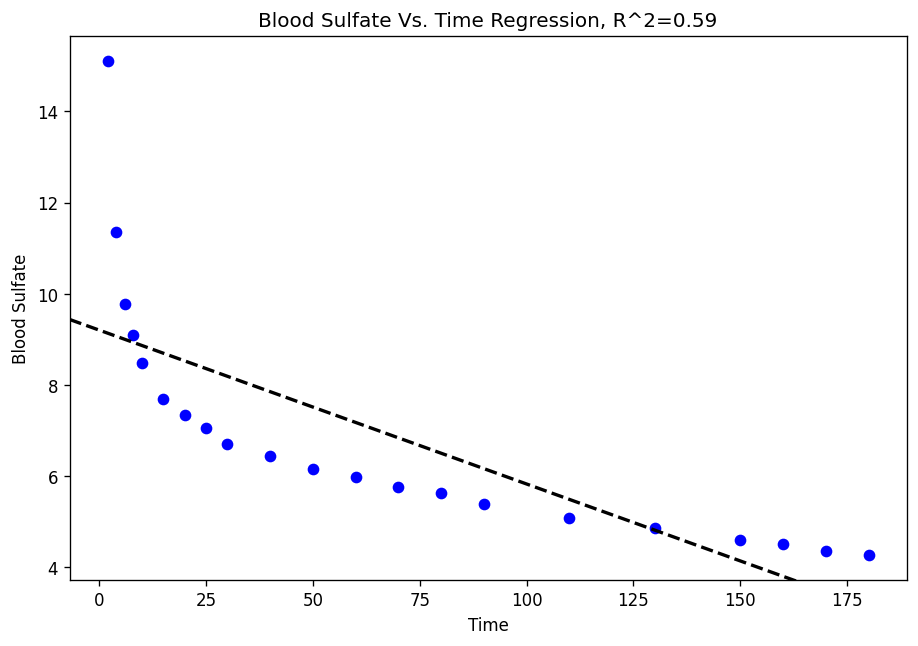

In [7]:
X_1 = df_1['Hours'].values.reshape(-1,1)
Y_1 = df_1['Sulfate'].values.reshape(-1)

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_1 = linear_regression(X_1,Y_1,lam=0)

ax = draw_regression(X_1,Y_1,beta_1,ax)

residuals_1 = linear_residuals(X_1, beta_1, Y_1)
fitted_1 = linear_predict(X_1, beta_1)

print("MSE:", np.mean(Y_1 - fitted_1)**2)

r2_1 = r2_score(Y_1, fitted_1) #computes the R^2 score

ax.set_xlabel('Time')
ax.set_ylabel('Blood Sulfate')
_ = ax.set_title('Blood Sulfate Vs. Time Regression, R^2=%.2f' %r2_1)

Lets compare my result with an off-the-shelf package. The package`seaborn` does the whole linear regression process in a single line. Let's try that, and see how it matches with my plot.

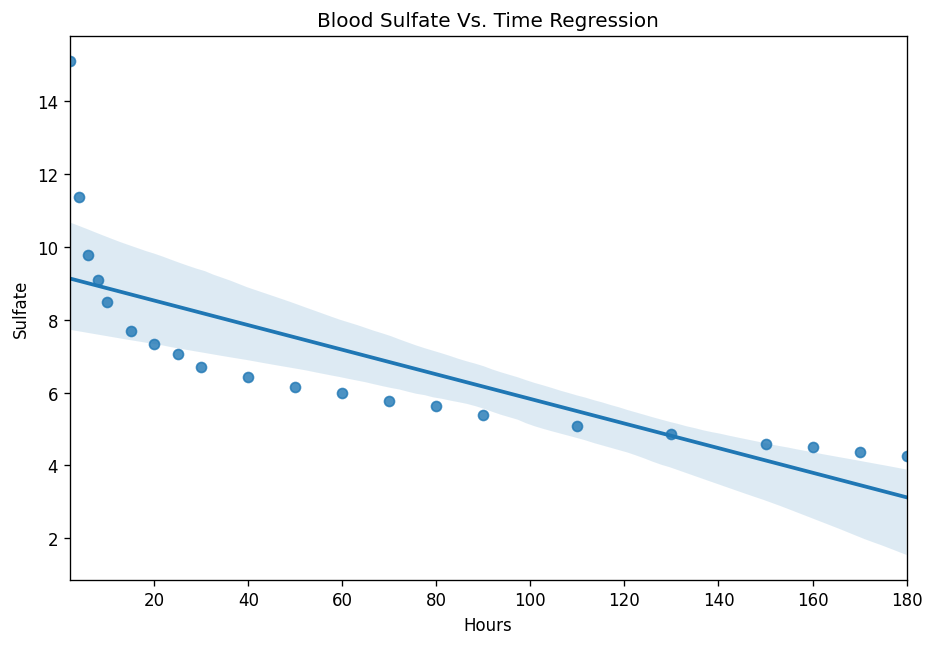

In [8]:
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
sns.regplot(x='Hours', y='Sulfate', data=df_1, ax=ax)
_ = ax.set_title('Blood Sulfate Vs. Time Regression')

Now draw the residuals against the fitted values.

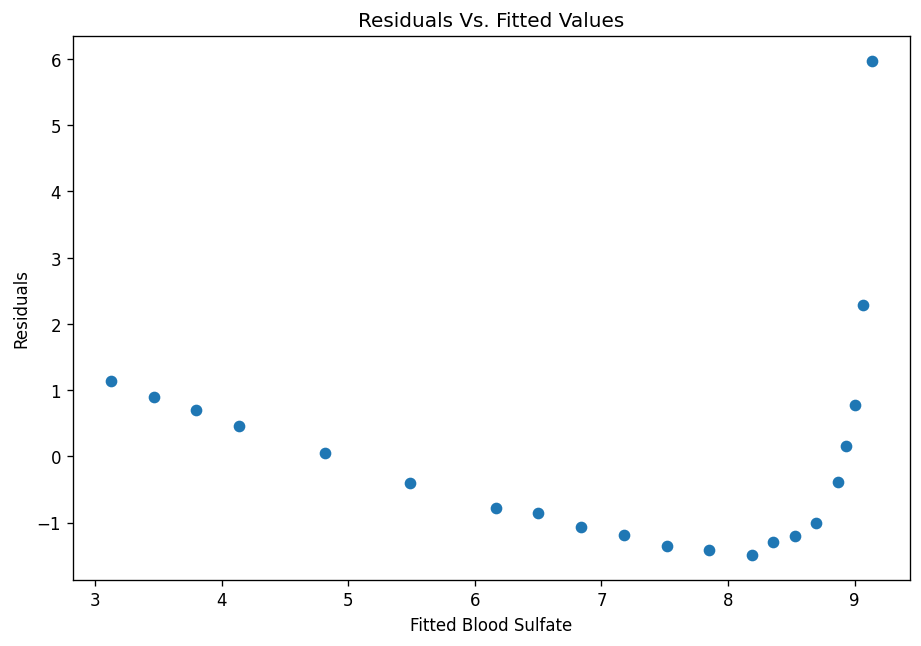

In [9]:
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
ax.scatter(fitted_1, residuals_1)

ax.set_xlabel('Fitted Blood Sulfate')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Values')

### Regression in the Log-Log Coordinates
Next, I find the linear regression for the log of the blood sulfate level against the log of time. I first use the `linear_regression` and `linear_residuals` functions that I implemented above.

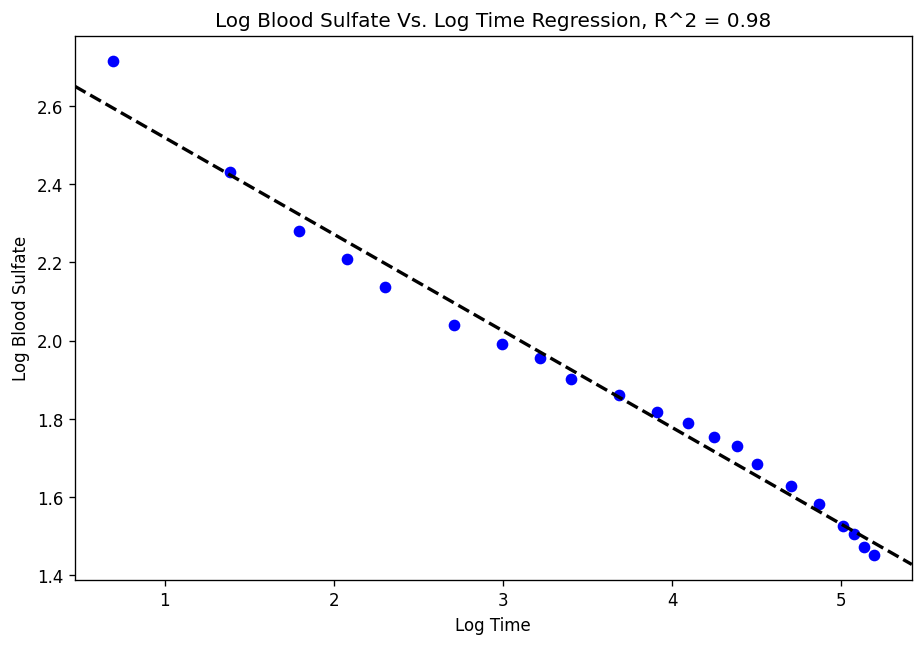

In [10]:
log_X_1 = np.log(df_1['Hours'].values.reshape(-1,1))
log_Y_1 = np.log(df_1['Sulfate'].values.reshape(-1))

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_1_log = linear_regression(log_X_1,log_Y_1,lam=0)
residuals_1_log = linear_residuals(log_X_1, beta_1_log, log_Y_1)
fitted_1_log = linear_predict(log_X_1, beta_1_log)

r2_1_log = r2_score(log_Y_1, fitted_1_log) #computes the R^2 score

ax = draw_regression(log_X_1,log_Y_1,beta_1_log,ax)

ax.set_xlabel('Log Time')
ax.set_ylabel('Log Blood Sulfate')
_ = ax.set_title('Log Blood Sulfate Vs. Log Time Regression, R^2 = %.2f' %r2_1_log)

We also compare our plot with the `seaborn` package.

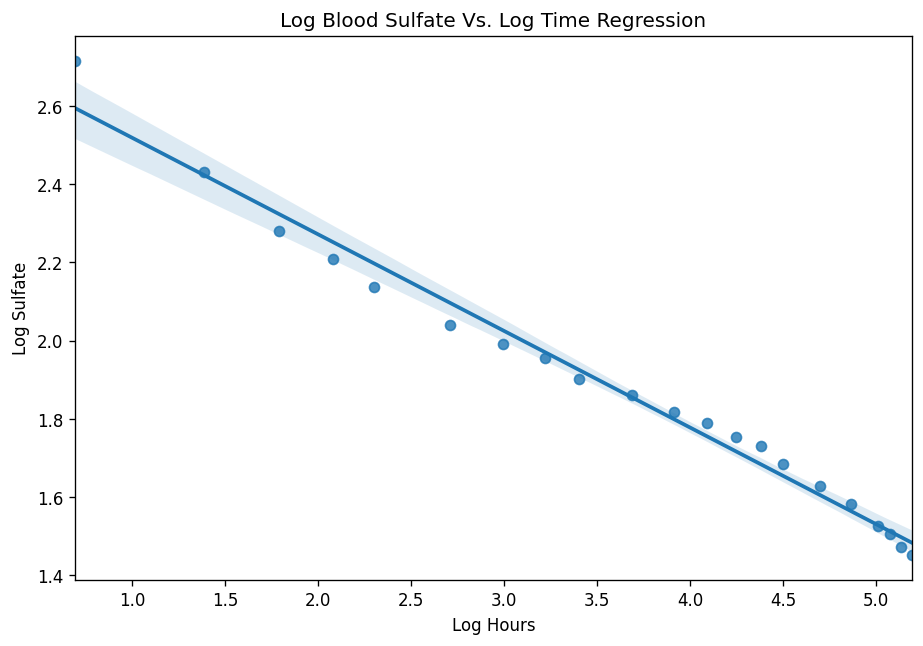

In [11]:
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
log_df_1 = df_1.copy(deep=True)
log_df_1['Log Hours'] = np.log(df_1['Hours'])
log_df_1['Log Sulfate'] = np.log(df_1['Sulfate'])
sns.regplot(x='Log Hours', y='Log Sulfate', data=log_df_1, ax=ax)
_ = ax.set_title('Log Blood Sulfate Vs. Log Time Regression')

And also plot the residuals against fitted log blood sulfate.

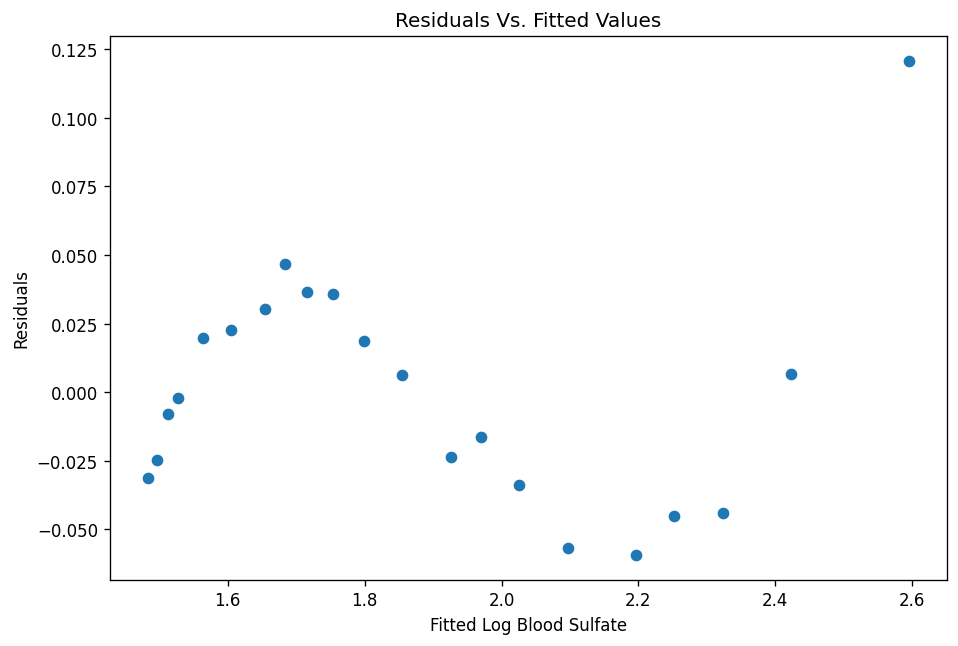

In [12]:
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
ax.scatter(fitted_1_log, residuals_1_log)

ax.set_xlabel('Fitted Log Blood Sulfate')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Values')

---

# Problem 2

## Data
At http://www.statsci.org/data/oz/physical.html, you will find a dataset of measurements by M. Larner, made in 1996. These measurements include body mass, and various diameters. I will build a linear regression of predicting the body mass from these diameters.

* **Input/Output**: This data has 11 columns, with the first column being the body mass and label.
* **Missing Data**: There is no missing data.
* **Final Goal**: Fit a linear regression model.

In [13]:
df_2 = pd.read_csv('Data/Physical.txt', sep='\t')
df_2

,Mass,Fore,Bicep,Chest,Neck,Shoulder,Waist,Height,Calf,Thigh,Head
0,77.0,28.5,33.5,100.0,38.5,114.0,85.0,178.0,37.5,53.0,58.0
1,85.5,29.5,36.5,107.0,39.0,119.0,90.5,187.0,40.0,52.0,59.0
2,63.0,25.0,31.0,94.0,36.5,102.0,80.5,175.0,33.0,49.0,57.0
3,80.5,28.5,34.0,104.0,39.0,114.0,91.5,183.0,38.0,50.0,60.0
4,79.5,28.5,36.5,107.0,39.0,114.0,92.0,174.0,40.0,53.0,59.0
5,94.0,30.5,38.0,112.0,39.0,121.0,101.0,180.0,39.5,57.5,59.0
6,66.0,26.5,29.0,93.0,35.0,105.0,76.0,177.5,38.5,50.0,58.5
7,69.0,27.0,31.0,95.0,37.0,108.0,84.0,182.5,36.0,49.0,60.0
8,65.0,26.5,29.0,93.0,35.0,112.0,74.0,178.5,34.0,47.0,55.5
9,58.0,26.5,31.0,96.0,35.0,103.0,76.0,168.5,35.0,46.0,58.0


## Regression

### Original Coordinates
I will first try to find the linear regression to predict the body mass based on the input diameters in the original coordinates. For this, I plot the residuals against the fitted mass. Similar to Problem 1, I do not use regularization and hence $\lambda=0$.

mean square error: 2.61


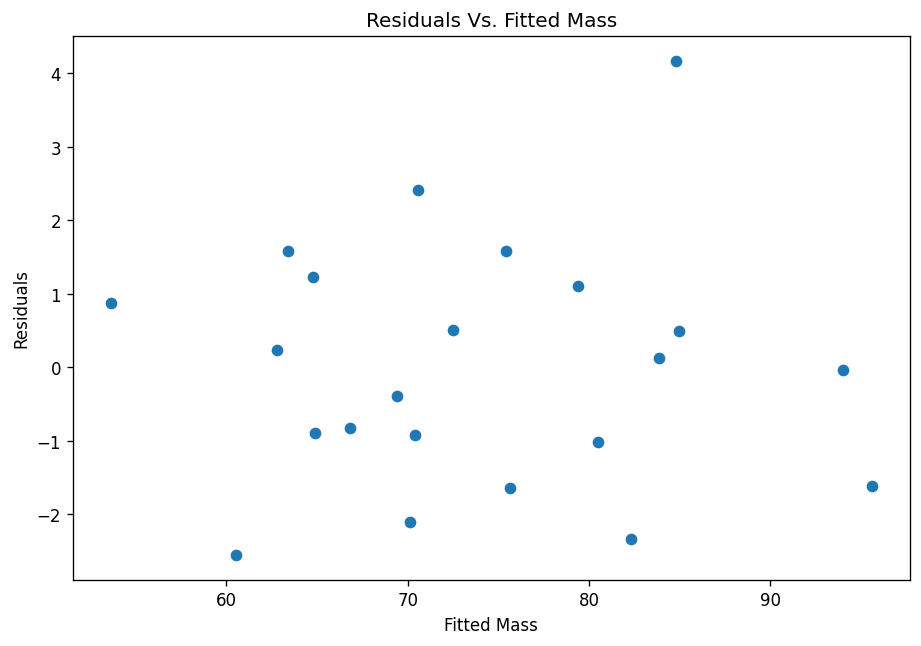

In [14]:
X_2 = df_2.loc[:, df_2.columns != 'Mass'].values
Y_2 = df_2['Mass'].values

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_2 = linear_regression(X_2,Y_2,lam=0)
residuals_2 = linear_residuals(X_2, beta_2, Y_2)
fitted_2 = linear_predict(X_2, beta_2)

ax.scatter(fitted_2, residuals_2)

ax.set_xlabel('Fitted Mass')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Mass')

print('mean square error: %.2f' %np.mean(residuals_2**2))

### Cubic Root Labels
Now, I find the linear regression between the input variables and the cubic root of the body mass. Then, I will plot cubic root residuals against fitted cubic root mass.

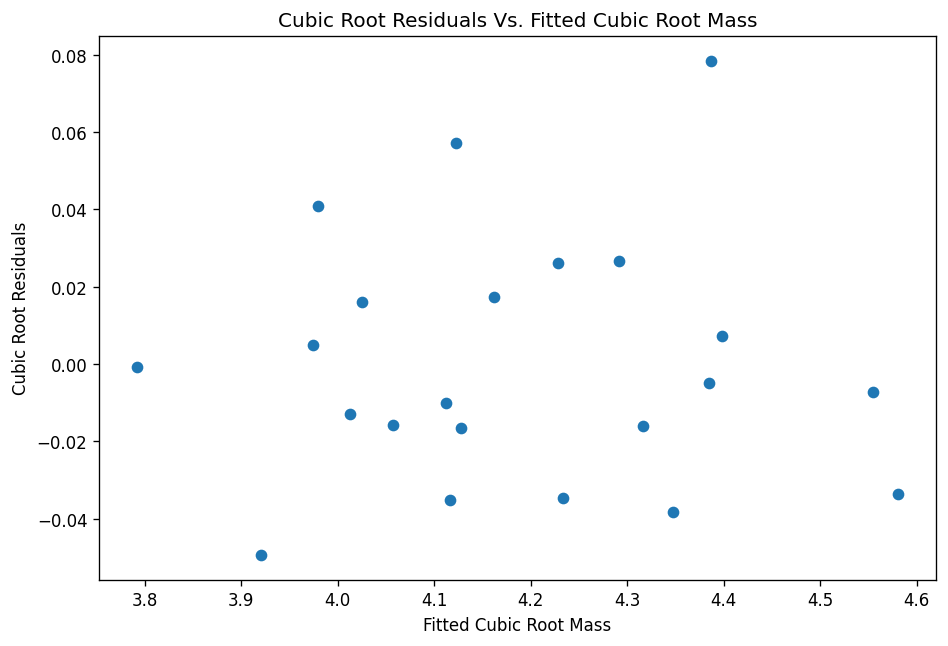

In [15]:
X_2 = df_2.loc[:, df_2.columns != 'Mass'].values
Y_2_cr = (df_2['Mass'].values**(1./3.))

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_2_cr = linear_regression(X_2,Y_2_cr,lam=0)
residuals_2_cr = linear_residuals(X_2, beta_2_cr, Y_2_cr)
fitted_2_cr = linear_predict(X_2, beta_2_cr)

ax.scatter(fitted_2_cr, residuals_2_cr)

ax.set_xlabel('Fitted Cubic Root Mass')
ax.set_ylabel('Cubic Root Residuals')
_ = ax.set_title('Cubic Root Residuals Vs. Fitted Cubic Root Mass')

---

# Problem 3

## Data
At https://archive.ics.uci.edu/ml/datasets/Abalone, you will find a dataset of measurements by W. J. Nash, T. L. Sellers, S. R. Talbot, A. J. Cawthorn and W. B. Ford, made in 1992. These are a variety of measurements of blacklip abalone (Haliotis rubra; delicious by repute) of various ages and genders.

* **Input/Output**: This data has 9 columns, with the last column being the rings count which serves as the age of the abalone and the label.
* **Missing Data**: There is no missing data.
* **Final Goal**: Fit a linear regression model predicting the age.

In [16]:
df_3 = pd.read_csv('Data/Abalone.data', sep=',', header=None)
df_3.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 
                'Viscera weight', 'Shell weight', 'Rings']
df_3

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


## Predicting the age from the measurements, ignoring gender

Our goal is to predict the number of rings against the input variables. However, since the input gender variable is discrete (it is one of the three values `M`, `F`, or `I`), I will first ignore the gender input.

mean square error = 4.91


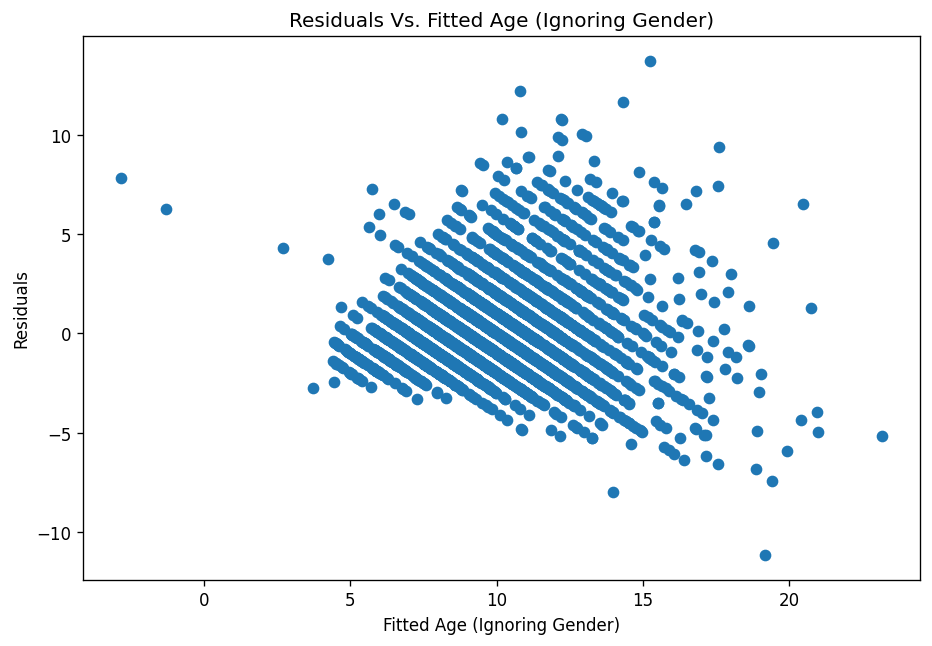

In [17]:
X_3 = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
Y_3 = df_3['Rings'].values

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_3 = linear_regression(X_3,Y_3,lam=0)
residuals_3 = linear_residuals(X_3, beta_3, Y_3)
fitted_3 = linear_predict(X_3, beta_3)

ax.scatter(fitted_3, residuals_3)

ax.set_xlabel('Fitted Age (Ignoring Gender)')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Age (Ignoring Gender)')

print('mean square error = %.2f' %np.mean(residuals_3**2))

## Predicting the age from the measurements, including gender
Now, lets convert gender into a numeric value by replacing `F` with 1, `M` with 0, and `I` with -1. Then, we again run the linear regression.

mean square error = 4.85


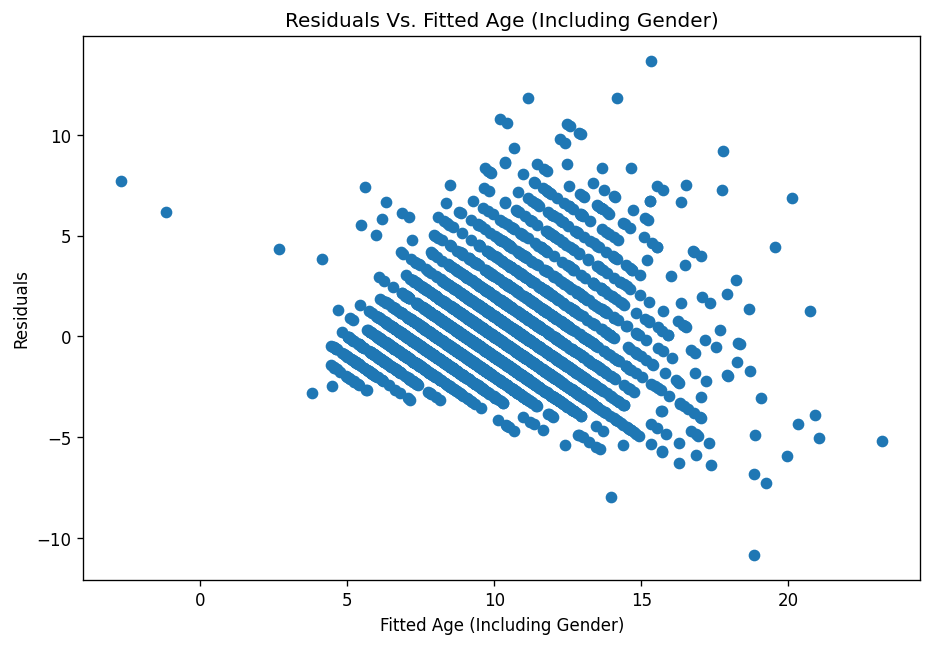

In [18]:
X_3_gender = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
X_3_gender = np.concatenate([X_3, np.array([{'F':1, 'M':0, 'I':-1}.get(x) for x in df_3.Sex]).reshape(-1,1)], axis=1)
Y_3 = df_3['Rings'].values

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_3_gender = linear_regression(X_3_gender,Y_3,lam=0)
residuals_3_gender = linear_residuals(X_3_gender, beta_3_gender, Y_3)
fitted_3_gender = linear_predict(X_3_gender, beta_3_gender)

ax.scatter(fitted_3_gender, residuals_3_gender)

ax.set_xlabel('Fitted Age (Including Gender)')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Age (Including Gender)')

print('mean square error = %.2f' %np.mean(residuals_3_gender**2))

## Predicting the log of age from the measurements, ignoring gender
Find the linear regression of the log of the output against the input variables, ignoring gender.

mean square error (in the original coordinates) = 5.31


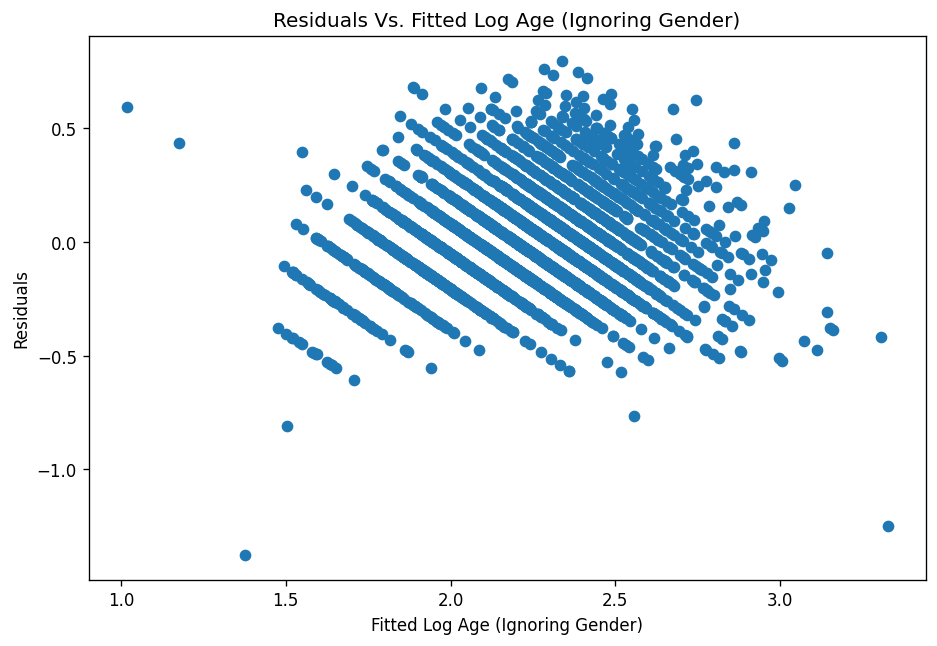

In [19]:
X_3 = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
Y_3 = df_3['Rings'].values
Y_3_log = np.log(df_3['Rings'].values)

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_3_log = linear_regression(X_3,Y_3_log,lam=0)
residuals_3_log = linear_residuals(X_3, beta_3_log, Y_3_log)
fitted_3_log = linear_predict(X_3, beta_3_log)

ax.scatter(fitted_3_log, residuals_3_log)

ax.set_xlabel('Fitted Log Age (Ignoring Gender)')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Log Age (Ignoring Gender)')

fitted_3_log_orig = np.exp(fitted_3_log) #predicted values back to the original coordinates
residuals_3_log_orig = Y_3 - fitted_3_log_orig #residuals in the original coordinates
print('mean square error (in the original coordinates) = %.2f' %np.mean(residuals_3_log_orig**2))

## Predicting the log age from the measurements, including gender
Use the same numeric values for the gender and find the linear regression to predict the log of the output against the input variables.

mean square error (in the original coordinates) = 5.24


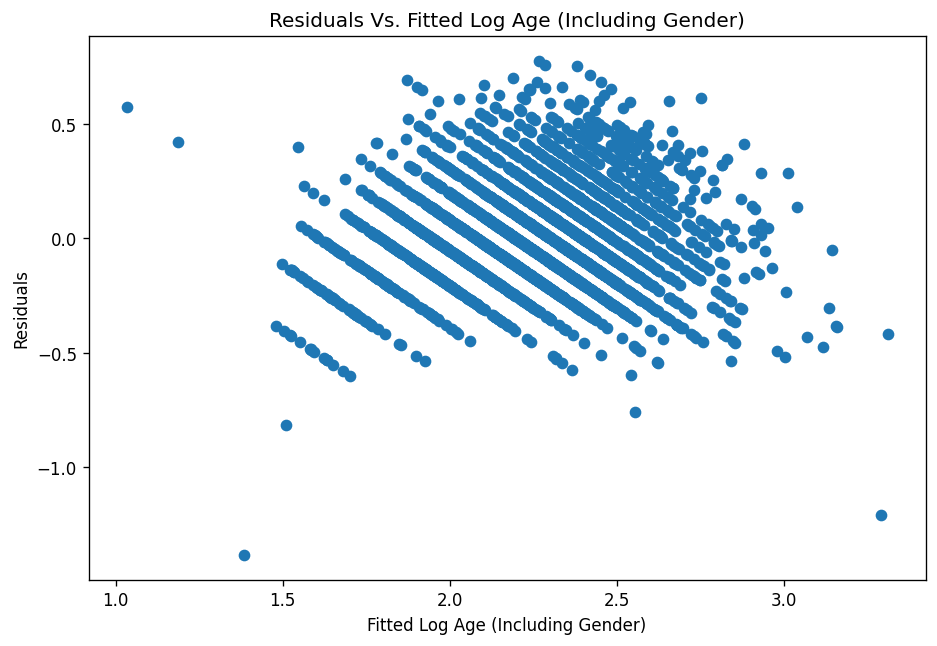

In [20]:
X_3_gender = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
X_3_gender = np.concatenate([X_3_gender, np.array([{'F':1, 'M':0, 'I':-1}.get(x) for x in df_3.Sex]).reshape(-1,1)], axis=1)
Y_3 = df_3['Rings'].values
Y_3_log = np.log(df_3['Rings'].values)

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_3_gender_log = linear_regression(X_3_gender,Y_3_log,lam=0)
residuals_3_gender_log = linear_residuals(X_3_gender, beta_3_gender_log, Y_3_log)
fitted_3_gender_log = linear_predict(X_3_gender, beta_3_gender_log)

ax.scatter(fitted_3_gender_log, residuals_3_gender_log)

ax.set_xlabel('Fitted Log Age (Including Gender)')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Log Age (Including Gender)')

fitted_3_gender_log_orig = np.exp(fitted_3_gender_log) # predicted values back to the original coordinates
residuals_3_gender_log = Y_3 - fitted_3_gender_log_orig
print('mean square error (in the original coordinates) = %.2f' %np.mean(residuals_3_gender_log**2))


## Applying Cross Validation For Regularization
Use cross validation to find the value of $\lambda$ to predict the log of the output variable against all the input variables. I convert the gender input to a numeric value using the conversion implemented above and then plot the cross-validation mean square error against the log of $\lambda$.

In the following code, the variable `Y_transform` determines whether we try to predict the labels in the original coordinates or in the logarithmic space. If the value of `Y_transform` is `linear`, we apply linear transformation in the original coordinates, and if its value is `log`, we use logarithmic transformation. In case we work in the logarithmic space, in order to find the mean square error, after finding the predicted values, we transform them back into the original coordinates using `np.exp` and then compare them to the correct values.

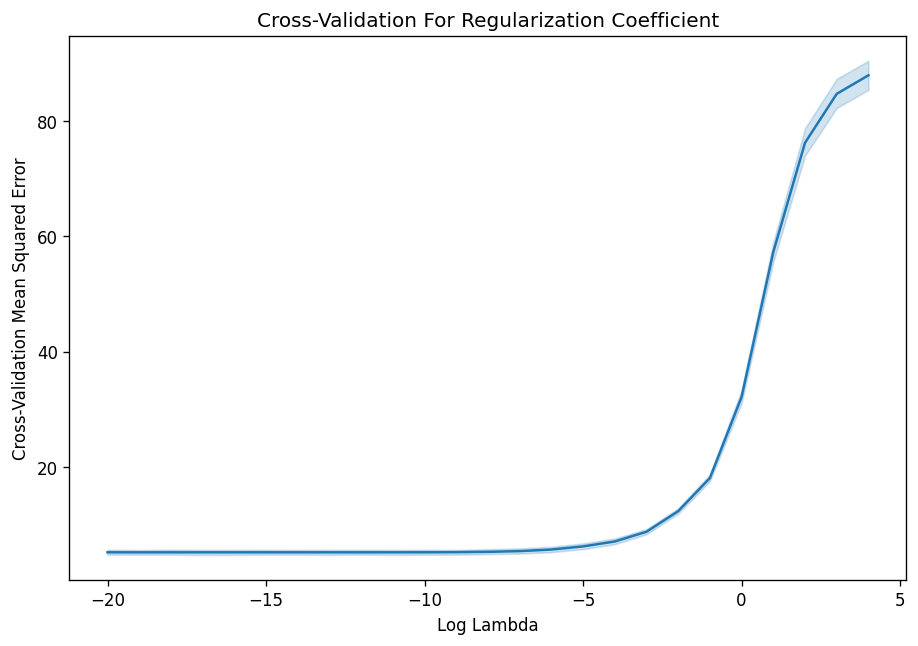

In [21]:
log_lambda_list = np.arange(-20, 5)
X_3_gender = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
X_3_gender = np.concatenate([X_3_gender, np.array([{'F':1, 'M':0, 'I':-1}.get(x) for x in df_3.Sex]).reshape(-1,1)], axis=1)
Y_3 = df_3['Rings'].values
Y_3_log = np.log(df_3['Rings'].values)

Y_transform = 'log' # 'linear': output variable in the original coordinate is considered, 'log': log of output is considered

if Y_transform == 'linear':
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_3_gender, Y_3, test_size=0.2, random_state=12345, shuffle=True)
if Y_transform == 'log':
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_3_gender, Y_3_log, test_size=0.2, random_state=12345, shuffle=True)

kf = KFold(n_splits=10, shuffle=True, random_state=12345)

cross_val_mses = []
for train_idx, val_idx in kf.split(X_train_val):
    X_train, X_val, Y_train, Y_val = X_train_val[train_idx], X_train_val[val_idx], Y_train_val[train_idx], Y_train_val[val_idx]
    
    for log_lambda in log_lambda_list:
        beta_3_cv = linear_regression(X_train, Y_train, lam=np.exp(log_lambda))
        if Y_transform == 'linear':
            val_residuals = linear_residuals(X_val, beta_3_cv, Y_val)
            
        if Y_transform == 'log':
            val_predict_log = linear_predict(X_val, beta_3_cv) # predicted in log space
            val_predict_log_orig = np.exp(val_predict_log) # get back to original coordinates

            val_residuals = np.exp(Y_val) - val_predict_log_orig
            
        val_mse = np.mean(val_residuals**2)
        
        cross_val_mses.append([log_lambda, val_mse])

cross_val_mses = np.array(cross_val_mses)
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
x_name, y_name = 'Log Lambda', 'Cross-Validation Mean Squared Error'
cv_df = pd.DataFrame(cross_val_mses, columns =[x_name, y_name])
sns.lineplot(x=x_name, y=y_name,data=cv_df, ax=ax)
_ = ax.set_title('Cross-Validation For Regularization Coefficient')

Lets see what was the best value of $\lambda$ and the corresponding mean square error.

In [22]:
avg_cv_err_df = cv_df.groupby(x_name).mean()
best_log_lam = avg_cv_err_df[y_name].idxmin()
best_cv_mse = avg_cv_err_df.loc[best_log_lam][y_name]

print(f'Best Log Lambda value was {best_log_lam} with a cross-validation MSE of %.3f' %best_cv_mse)

beta_full = linear_regression(X_train_val,Y_train_val,lam=np.exp(best_log_lam))

if Y_transform == 'linear':
    test_residuals = linear_residuals(X_test, beta_full, Y_test)
    test_mse = np.mean(test_residuals**2)
if Y_transform == 'log':
    test_predict = linear_predict(X_test, beta_full)
    test_predict_orig = np.exp(test_predict)
    test_residuals = np.exp(Y_test) - test_predict_orig
    test_mse = np.mean(test_residuals**2)
print(f'The resulting test mean squared error would be %.3f' % test_mse)

Best Log Lambda value was -13.0 with a cross-validation MSE of 5.144
The resulting test mean squared error would be 10.706
